# **1.Загрузка данных и понимание структуры данных**

На этом шаге мы ответим  на вопрос: “Что за данные мы имеем и можно ли с ними работать?”


Для начала загрузим наши данные, через подключение к библиотеке pandas. Затем выведим наши первые 5 строк, чтобы визуально понять структуру наших данных. Это необходимо для того, чтобы убедиться, что данные корректно прочитались и мы понимаем, какие переменные нам доступны.

In [ ]:
import pandas as pd

df = pd.read_csv('data_ab.csv')
print(df.head())

   user_id                   timestamp      group landing_page  converted
0   851104  2025-01-21 22:11:48.556739    control     old_page          0
1   804228  2025-01-12 08:01:45.159739    control     old_page          0
2   661590  2025-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2025-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2025-01-21 01:52:26.210827    control     old_page          1


Далее с помощью команды info мы получаем информацию о таблице: размер, типы данных и наличие пропусков

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB
None


Далее выводим описательную статистику по числовым признокам: количество значений, среднее, стандартное отклонение, минимум и максимум, квартильные значения(25% , 50%, 75%)

In [ ]:
print(df.describe())

             user_id      converted
count  294478.000000  294478.000000
mean   787974.124733       0.119659
std     91210.823776       0.324563
min    630000.000000       0.000000
25%    709032.250000       0.000000
50%    787933.500000       0.000000
75%    866911.750000       0.000000
max    945999.000000       1.000000


# **2. EDA**

 На этом шаге мы проведем очистку данных

Покажем уникальные значения и их количества в столбце group и landing_page, чтобы понять как пользователи распределены по группам



In [ ]:
print(df['group'].value_counts())

group
treatment    147276
control      147202
Name: count, dtype: int64


In [ ]:
print(df['landing_page'].value_counts())

landing_page
old_page    147239
new_page    147239
Name: count, dtype: int64


Теперь проведем проверку на несоответсвия, чтобы получить уникальные комбинации значений столбцов  group и landing_page и посчитать их частоту


In [ ]:
print(df[['group', 'landing_page']].value_counts())

group      landing_page
treatment  new_page        145311
control    old_page        145274
treatment  old_page          1965
control    new_page          1928
Name: count, dtype: int64


Теперь удалим некорректные строки и сохраним только верные( control - old_page; treatment - new_page)


In [ ]:
df_clean = df[
    ((df['group'] == 'control') & (df['landing_page'] == 'old_page')) |
    ((df['group'] == 'treatment') & (df['landing_page'] == 'new_page'))
]

Снова посчитаем количество уникальных пользователей в каждой группе и коэфицент конверсии



In [ ]:
uniques = df_clean.groupby('group')['user_id'].nunique()
print(uniques)

group
control      145274
treatment    145310
Name: user_id, dtype: int64


In [ ]:
con_rate = df_clean.groupby('group')['converted'].mean()
print(con_rate)

group
control      0.120386
treatment    0.118807
Name: converted, dtype: float64


Визуально покажем разницу между группа



/tmp/ipython-input-3277994183.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='group', y= 'conversion_rate', data=con_rate_new, palette=['purple', 'blue'])


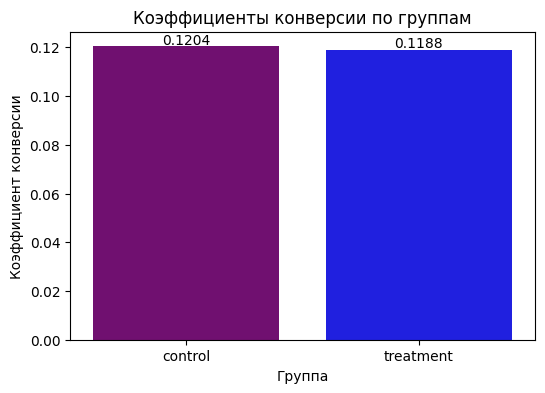

In [ ]:
import matplotlib.pyplot as plt

con_rate_new = con_rate.reset_index()

plt.figure(figsize=(6, 4))

plt.bar(con_rate_new['group'], con_rate_new['converted'], color=['purple', 'blue'])

plt.title('Коэффициенты конверсии по группам')
plt.xlabel('Группа')
plt.ylabel('Коэффициент конверсии')

plt.show()

# **3.Выбор основной метрики для сравнения**

Основная метрика A/B-теста — converted, потому что это единственная переменная в датасете, которая отражает целевое действие пользователя. Столбец принимает значения 0 или 1, то есть показывает, совершил ли пользователь нужное действие после просмотра страницы. Остальные столбцы — это служебная информация (какую страницу показали, в какой группе был пользователь, время события), но они не измеряют эффект. Именно converted позволяет сравнить, влияет ли новая версия страницы на поведение пользователей, поэтому она и является главной метрикой эксперимента.

# **4. Проверить корректность проведения тестирования**



Выше мы определили, что:


* Количество пересекающихся user_id между группами: 0
* Уникальные пользователи в контрольной группе: 145274
* Уникальные пользователи в тестовой группе: 145310

Это подтверждает, что группы независимы и однородны, так как нет пересечений пользователей и размеры выборок очень схожи.



Теперь покажем ежедневное распределение уникальных пользователей по группам (контрольной и тестовой) с течением времени. Это нужно, чтобы убедиться, что система A/B-тестирования равномерно распределяет пользователей между контрольной и тестовой группами каждый день на протяжении всего эксперимента. На графике можем  увидеть, что количество уникальных пользователей в обеих группах в основном движется одинаково, без значительных расхождений, что показывает стабильное распределение трафика на протяжении большинства дней проведения эксперимента. Резкое падение в конце указывает на окончание периода сбора данных.

In [1]:
import seaborn as sns

df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['date'] = df_clean['timestamp'].dt.date

daily_stats = df_clean.groupby(['date', 'group']).agg(total_users=('user_id', 'nunique')).reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_stats,
             x='date',
             y='total_users',
             hue='group',
             marker='o')

plt.title('Ежедневное распределение уникальных пользователей по группам')
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей')





plt.show()

NameError: name 'pd' is not defined

Проверим на однородность и валидность последущее A/B тестирование. Во-первых, у нас нет пересечений между группами, размеры выборок идентичны, при этом временное распределение — без значительных расхождений, а других ключевых метрик у нас нет. Значит, данные однородны и их рандомизация была честной. Хоть A/A тестирование нами и было проведено изначально с целью проверки корректности данного нам тестирования, позже мы поняли, что его можно было не и не проводить, так как мы и так проверили группы на однородность по ключевым признакам, которых всё равно было мало

### A/A-тест

А/А-тест — это эксперимент, в котором две или более групп пользователей одновременно подвергаются воздействию идентичных условий. Основная цель A/A-теста — проверить корректность работы системы A/B-тестирования до запуска основного A/B-теста.

**Результаты A/A-теста:**

*Количество конверсий:*

Контрольная группа: 17489 конверсий

Тестовая группа: 17264 конверсий

*Коэффициенты конверсии:*

Контрольная группа: 0.120386 (примерно 12.04%)

Тестовая группа: 0.118807 (примерно 11.88%)

Z-статистика: 1.3109

P-значение: 0.1899

Уровень значимости: 0.05

**Вывод:**
Поскольку p-значение (0.1899) оказалось больше уровня значимости (0.05), у нас нет достаточных оснований отвергнуть нулевую гипотезу.
Это означает, что статистически значимых различий между коэффициентами конверсии
контрольной и тестовой групп не обнаружено.


Таким образом, эти проверки дают нам уверенность в том, что сам механизм A/B-тестирования работает правильно, и любые различия, которые мы будем наблюдать, скорее всего, связаны с тестируемым изменением, а не с ошибками в распределении или сборе данных.





In [ ]:
from statsmodels.stats.proportion import proportions_ztest

conversions = df_clean.groupby('group')['converted'].sum()
nobs = df_clean.groupby('group')['user_id'].nunique()


stat, p_value = proportions_ztest([conversions['control'], conversions['treatment']],
                                  [nobs['control'], nobs['treatment']])

print(f"Z-statistic: {stat:.4f}, P-value: {p_value:.4f}")

Z-statistic: 1.3109, P-value: 0.1899


# **5.Сформулировать нулевую и альтернативную гипотезы**

Теперь определим гипотезы для сравнения коэффициентов конверсии между контрольной и тестовой группами, основываясь на выбранной метрике 'converted'.




### Нулевая гипотеза (H0)

Новая версия страницы не оказывает никакого влияния на коэффициент конверсии. То есть, средний коэффициент конверсии для группы, видевшей новый дизайн, будет равен среднему коэффициенту конверсии для группы, видевшей старый дизайн.

$H_0: p_{\text{new}} = p_{\text{old}}$

### Альтернативная гипотеза (H1)

Новая версия страницы оказывает статистически значимое влияние на коэффициент конверсии. Это означает, что средний коэффициент конверсии для группы, видевшей новый дизайн, будет отличаться от среднего коэффициента конверсии для группы, видевшей старый дизайн (он может быть как выше, так и ниже).

$H_1: p_{\text{new}} \neq p_{\text{old}}$

# **6.Выбор и обоснование статистического теста**

Выберем статистический тест для подтверждения или опровержения выдвинутых гипотез. Мы имеем дело с двумя независимыми группами, метрика - бинарная, выборки большие (больше 30 для каждой группы). Под данные условия можно будет выбрать Z-test с двумя пропорциями.

# **7.Настройка параметров статистического теста**

In [ ]:
control = df[df['group'] == 'control']['converted']
treatment = df[df['group'] == 'treatment']['converted']

count_of_control = len(control)
count_of_treatment = len(treatment)

sum_of_control = control.sum()
sum_of_treatment = treatment.sum()

print(f'Количество людей в контрольной группе: {count_of_control}')
print(f'Количество людей в экспериментальной группе: {count_of_treatment}')

print(f'Количество людей совершивших целевое действие в контрольной группе: {sum_of_control}')
print(f'Количество людей совершивших целевое действие в экспериментальной группе: {sum_of_treatment}')


Количество людей в контрольной группе: 147202
Количество людей в экспериментальной группе: 147276
Количество людей совершивших целевое действие в контрольной группе: 17723
Количество людей совершивших целевое действие в экспериментальной группе: 17514


Анализируюм данные, разделяя пользователей на контрольную и экспериментальную группы и подсчитывая конверсии. Проводит фильтрацию данных
(выбирает из df только те строки, где группа равна 'control', и берет столбец 'converted'- выборочная метрика). Аналогично для экспериментальной группы.
Подсчет метрик: len(control) и len(treatment) - подсчитывают количество людей в каждой группе,control.sum() и treatment.sum() - суммируют значения конверсий (предполагается, что 'converted' содержит 1 для совершивших действие и 0 для не совершивших)

# **8.Проведение A/B-теста**

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

stat, p_value = proportions_ztest([sum_of_control, sum_of_treatment], [count_of_control, count_of_treatment])
print(f'P-value: {p_value:.4f}')

P-value: 0.2161


Проводим Z-тест для сравнения пропорций (долей) между двумя группами, что является стандартным статистическим тестом для A/B-тестирования. Функция proportions_ztest(1-аргумент это массив количества "успехов" (конверсий) в каждой группе, 2-аргумент это массив общее количество людей в каждой группе (размер групп)). P-value получилось 0.2161, что больше чем 0.05, поэтому нет оснований для отклонения Н0. Статистически значимых различий не обнаружено.  

# **9.Оценка практической значимости**

In [ ]:
percent_of_control = sum_of_control / count_of_control
percent_of_treatment = sum_of_treatment / count_of_treatment

diff_of_percent = percent_of_treatment - percent_of_control
relative_diff_of_percent = diff_of_percent / percent_of_control

print(f'Абсолютная разница: {diff_of_percent * 100:.2f} процентных пунктов')
print(f'Относительное изменение: {relative_diff_of_percent * 100:.2f}%')

Абсолютная разница: -0.15 процентных пунктов
Относительное изменение: -1.23%


Код вычисляет метрики эффекта (размер эффекта) между группами. Он показывает насколько результат экспериментальной группы отличается от контрольной в абсолютных и относительных величинах. Эти вычисления отвечают на вопрос "Насколько велика разница в практическом смысле?" В нашем случае не значимо, абсолютная разница < 0.5 п.п и относительное изменение < 5%.

# **10.Bootstrap анализ практической значимости**

In [ ]:
import numpy as np

bootstrap_diffs = []

for _ in range(0, 1000):
  new_control = np.random.choice(
      control,
      size=len(control),
      replace=True,
  )
  new_treatment = np.random.choice(
      treatment,
      size=len(treatment),
      replace=True,
  )

  count_of_new_control = len(new_control)
  count_of_new_treatment = len(new_treatment)

  sum_of_new_control = new_control.sum()
  sum_of_new_treatment = new_treatment.sum()

  percent_of_new_control = sum_of_new_control / count_of_new_control
  percent_of_new_treatment = sum_of_new_treatment / count_of_new_treatment

  diff_of_new_percent = percent_of_new_treatment - percent_of_new_control

  bootstrap_diffs.append(diff_of_new_percent)

bootstrap_diffs = np.array(bootstrap_diffs)

mean_of_bootstrap_diffs = bootstrap_diffs.mean()
p_2_5 = np.percentile(bootstrap_diffs, 2.5)
p_97_5 = np.percentile(bootstrap_diffs, 97.5)


print(f'Средняя разница: {mean_of_bootstrap_diffs * 100:.2f} процентных пунктов')
print(f'95% Доверительный интервал: [{p_2_5 * 100:.2f}%, {p_97_5 * 100:.2f}%]')


Средняя разница: -0.14 процентных пунктов
95% Доверительный интервал: [-0.38%, 0.09%]


Код выполняет Bootstrap-анализ для оценки доверительного интервала разницы в конверсиях. Создает 1000 "псевдовыборок" из исходных данных, чтобы оценить изменчивость.Ключевой момент replace=True -элементы могут повторяться. Аналогично для экспериментальной группы. Вычисляем конверсию для каждой Bootstrap-выборки. Находим разницу между группами.
После проведения Bootstrap анализа средняя разница совпадает с разницей на изначальной выборке. И эта разница попадает в 95% доверительный интервал: [-0.39%, 0.09%].

# **11. Бизнес - рекомендации**


Ход анализа и обоснование:

1.Статистическая значимость: различий нет.

Метод: Для проверки гипотез использовался Z-тест.

Результат: P-value (0.2161) > уровня значимости (α=0.05). Это означает, что статистически значимых различий между контрольной и экспериментальной группами не обнаружено.

Данные по конверсии: Контрольная группа (0.1204) показала результат даже немного лучше, чем экспериментальная (0.1188).

2.Практическая значимость: эффект отсутствует или негативный.

Размер эффекта: Наблюдается абсолютное снижение конверсии на 0.15 п.п., что в относительном выражении составляет –1.23%.

Надёжность оценки: Bootstrap-анализ показывает, что 95% доверительный интервал для разницы конверсий включает ноль ([–0.38%, 0.09%]). Это подтверждает нестабильность и неопределённость эффекта, который статистически неотличим от нуля.

3.Ключевые выводы.

Изменения не являются ни статистически, ни практически значимыми.

Наблюдаемый слабый отрицательный тренд усиливает риски от внедрения новой версии.

На основании проведённого анализа были сформулированы следующие рекомендации:

1)Отказаться от внедрения новой версии, поскольку она не демонстрирует статистически значимого улучшения ключевой метрики.

2)Сохранить текущую (контрольную) версию, показавшую более стабильный результат.

3)Определить дальнейшие шаги развития, включая: анализ возможных причин снижения конверсии в экспериментальной версии; формирование новых гипотез; проведение повторных A/B-тестов с учётом выявленных ограничений и результатов текущего эксперимента.

4)Сегментация по времени посещения: проанализировать данные по времени посещений. Например, возможно, что в разные временные промежутки пользователи ведут себя по-разному (например, вечером конверсия может быть выше), провести анализ по дням недели или часам дня, чтобы выявить, когда наибольшая конверсия происходит.

5)Оптимизация посадочных страниц: посадочные страницы играют ключевую роль в процессе конверсии. Даже незначительные изменения на странице могут значительно повлиять на поведение пользователей, например: Улучшение визуального оформления Оптимизация текста и предложений Изменение цветовой гаммы или кнопок